<a href="https://colab.research.google.com/github/Sohaib9920/Data_Visualization/blob/master/Transformer_Multilingual_Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task:** Perform NER for a customer based in Switzerland, where there are four national languages: German (62.9%), French (22.9%), Italian (8.4%), and English (5.9%)

In [4]:
!pip install -U datasets transformers accelerate seqeval

In [5]:
import datasets
import torch
import transformers
from transformers import XLMRobertaConfig, RobertaPreTrainedModel, RobertaModel, DataCollatorForTokenClassification, Trainer, TrainingArguments
from transformers.modeling_outputs import TokenClassifierOutput
from collections import defaultdict
import pandas as pd
from collections import Counter
import numpy as np
from seqeval.metrics import classification_report, f1_score

In [6]:
from huggingface_hub import notebook_login
notebook_login()

# Dataset

We will be using a subset of the Cross-lingual TRansfer Evaluation of
Multilingual Encoders (XTREME) benchmark called WikiANN or PAN-X

## Creating Data Subsets

In [7]:
xtreme_subsets = datasets.get_dataset_config_names("xtreme", trust_remote_code=True)
PAN_subsets = [s for s in xtreme_subsets if s.startswith("P")]
print(PAN_subsets)

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de', 'PAN-X.el', 'PAN-X.en', 'PAN-X.es', 'PAN-X.et', 'PAN-X.eu', 'PAN-X.fa', 'PAN-X.fi', 'PAN-X.fr', 'PAN-X.he', 'PAN-X.hi', 'PAN-X.hu', 'PAN-X.id', 'PAN-X.it', 'PAN-X.ja', 'PAN-X.jv', 'PAN-X.ka', 'PAN-X.kk', 'PAN-X.ko', 'PAN-X.ml', 'PAN-X.mr', 'PAN-X.ms', 'PAN-X.my', 'PAN-X.nl', 'PAN-X.pt', 'PAN-X.ru', 'PAN-X.sw', 'PAN-X.ta', 'PAN-X.te', 'PAN-X.th', 'PAN-X.tl', 'PAN-X.tr', 'PAN-X.ur', 'PAN-X.vi', 'PAN-X.yo', 'PAN-X.zh', 'PAWS-X.de', 'PAWS-X.en', 'PAWS-X.es', 'PAWS-X.fr', 'PAWS-X.ja', 'PAWS-X.ko', 'PAWS-X.zh']


In [8]:
langs = ["de", "fr", "it", "en"]
props = [0.629, 0.229, 0.084, 0.058]
panx = defaultdict(dict) # In order to directly assing the nested dict
for lang, prop in zip(langs, props):
    data_dict = datasets.load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in data_dict:
        selected_size = int(prop * data_dict[split].num_rows)
        panx[lang][split] = data_dict[split].shuffle(seed=42).select(range(selected_size))
        panx[lang] = datasets.DatasetDict(panx[lang])

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [9]:
df = pd.DataFrame({lang: panx[lang].num_rows for lang in langs})
df

,de,fr,it,en
train,12580,4580,1680,1160
validation,6290,2290,840,580
test,6290,2290,840,580


In [10]:
df.sum(axis=1)

train         20000
validation    10000
test          10000
dtype: int64

By design, we have more examples in German than all other languages combined, so
we’ll use it as a starting point from which to perform zero-shot cross-lingual transfer
to French, Italian, and English

In [11]:
tags = panx["de"]["train"].features["ner_tags"].feature
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

Each article is annotated with LOC (location), PER
(person), and ORG (organization) tags in the “inside-outside-beginning” (IOB2) format. In this format, a B-prefix indicates the beginning of an entity, and consecutive
tokens belonging to the same entity are given an I-prefix. An O tag indicates that the
token does not belong to any entity

In [12]:
panx_de = panx["de"].map(lambda example: {"ner_tags_str":tags.int2str(example["ner_tags"])})

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [13]:
pd.set_option("display.max_colwidth", None)
pd.DataFrame(panx_de["train"]).head(5)

,tokens,ner_tags,langs,ner_tags_str
0,"[Olympique, Nîmes, ,, Auxerres, seinerzeitiger, drittklassiger, Endspielgegner, ,, hatte, sich, erst, gar, nicht, für, die, Hauptrunde, qualifizieren, können, .]","[3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[de, de, de, de, de, de, de, de, de, de, de, de, de, de, de, de, de, de, de]","[B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,"[Alexander, Jakowlew, wies, deshalb, am, 18, .]","[1, 2, 0, 0, 0, 0, 0]","[de, de, de, de, de, de, de]","[B-PER, I-PER, O, O, O, O, O]"
2,"[Aktuell, werden, die, beiden, am, besten, erhaltenen, Tafeln, im, Alten, Museum, ausgestellt, .]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0]","[de, de, de, de, de, de, de, de, de, de, de, de, de]","[O, O, O, O, O, O, O, O, O, B-ORG, I-ORG, O, O]"
3,"[Sie, gehören, damit, mit, der, Dickschnabellumme, zu, den, schwersten, ,, derzeit, noch, lebenden, Alkenarten, .]","[0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[de, de, de, de, de, de, de, de, de, de, de, de, de, de, de]","[O, O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O]"
4,"[Auch, in, Garmisch-Partenkirchen, landete, er, auf, diesem, Platz, .]","[0, 0, 5, 0, 0, 0, 0, 0, 0]","[de, de, de, de, de, de, de, de, de]","[O, O, B-LOC, O, O, O, O, O, O]"


In [14]:
df = pd.DataFrame()
for split in panx_de:
    count = Counter()
    for row in panx_de[split]["ner_tags_str"]:
        count.update(row)
    df[split] = dict(count)

In [15]:
df.T

,B-ORG,I-ORG,O,B-PER,I-PER,B-LOC,I-LOC
train,5397,7647,86156,5881,8423,6169,2898
validation,2639,3774,43122,2870,4140,3172,1447
test,2657,3825,43170,2971,4260,3100,1404


This looks good—the distributions of the PER, LOC, and ORG frequencies are roughly
the same for each split, so the validation and test sets should provide a good measure
of our NER tagger’s ability to generalize.

# Tokenization

We will use XLM-Roberta model. The input data is already pretokenized. We need to further tokenize it into subwords represented in vocabulary of XLM-Roberta using its SentencePiece tokenizer.

In [16]:
# Comparing tokenizers
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = transformers.AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = transformers.AutoTokenizer.from_pretrained(xlmr_model_name)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [17]:
text = "Transformer models are cool n awsome!"
print(bert_tokenizer(text).tokens())
print(xlmr_tokenizer(text).tokens())

['[CLS]', 'Trans', '##former', 'models', 'are', 'cool', 'n', 'a', '##ws', '##ome', '!', '[SEP]']
['<s>', '▁Trans', 'former', '▁models', '▁are', '▁cool', '▁n', '▁a', 'w', 'some', '!', '</s>']


## Tokenizing and creating labels

We need to ignore the ner tags of subsequent subwords in our labels:

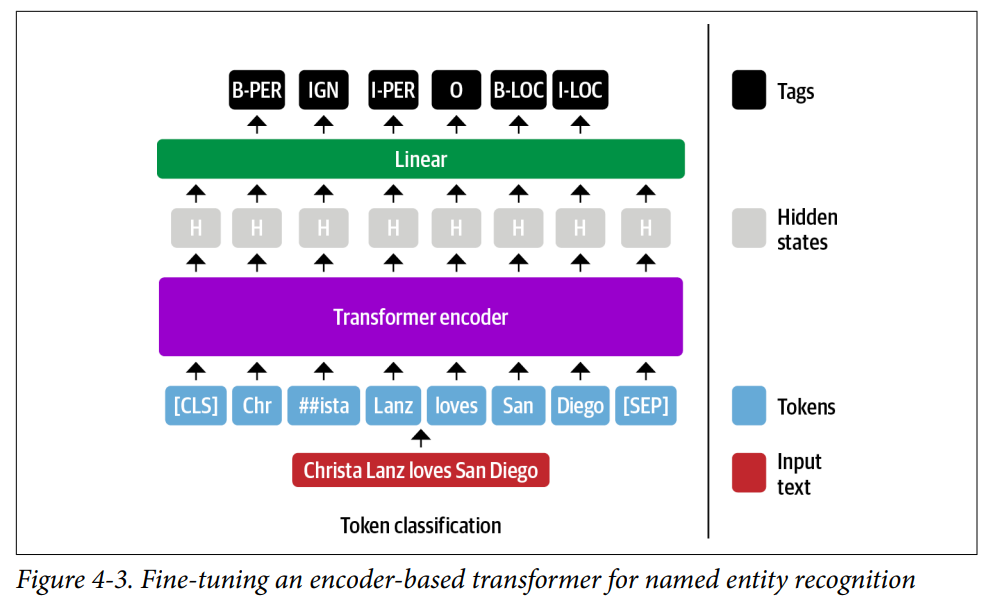

In [18]:
def tokenize_and_align_labels(batch):
    tokenized_inputs = xlmr_tokenizer(batch["tokens"], is_split_into_words=True, truncation=True)
    labels = []
    for row_idx, ner_tags in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(row_idx)
        sub_ner_tags = word_ids_to_sub_ner_tags(word_ids, ner_tags)
        labels.append(sub_ner_tags)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs # output BatchEncoding

def word_ids_to_sub_ner_tags(word_ids, ner_tags):
    prev_word_id = None
    sub_ner_tags = []
    for word_id in word_ids:
        if word_id is None or word_id == prev_word_id:
            sub_ner_tags.append(-100)
        else:
            sub_ner_tag = ner_tags[word_id]
            sub_ner_tags.append(sub_ner_tag)
        prev_word_id = word_id
    return sub_ner_tags

In [19]:
pd.DataFrame(panx_de["train"][:2])

,tokens,ner_tags,langs,ner_tags_str
0,"[Olympique, Nîmes, ,, Auxerres, seinerzeitiger, drittklassiger, Endspielgegner, ,, hatte, sich, erst, gar, nicht, für, die, Hauptrunde, qualifizieren, können, .]","[3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[de, de, de, de, de, de, de, de, de, de, de, de, de, de, de, de, de, de, de]","[B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,"[Alexander, Jakowlew, wies, deshalb, am, 18, .]","[1, 2, 0, 0, 0, 0, 0]","[de, de, de, de, de, de, de]","[B-PER, I-PER, O, O, O, O, O]"


In [20]:
pd.DataFrame(dict(tokenize_and_align_labels(panx_de["train"][:2])))

,input_ids,attention_mask,labels
0,"[0, 68237, 11503, 541, 52644, 90, 6, 4, 5655, 34058, 2109, 19742, 13653, 21358, 133793, 86060, 1505, 18878, 25421, 146957, 6, 4, 10264, 833, 18274, 3671, 749, 643, 68, 47582, 95611, 14768, 1029, 117484, 2556, 6, 5, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, -100, -100, 0, -100, 0, -100, -100, 0, -100, -100, 0, -100, -100, 0, -100, -100, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, -100, -100, 0, 0, -100, -100]"
1,"[0, 42814, 46184, 434, 71908, 1225, 7, 64791, 444, 543, 6, 5, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 1, 2, -100, -100, 0, -100, 0, 0, 0, 0, -100, -100]"


In [112]:
def encode_pax_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=["langs", "tokens", "ner_tags"])

panx_de_encoded = encode_pax_dataset(panx["de"])

pd.DataFrame(panx_de_encoded["train"][:3])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

,input_ids,attention_mask,labels
0,"[0, 68237, 11503, 541, 52644, 90, 6, 4, 5655, 34058, 2109, 19742, 13653, 21358, 133793, 86060, 1505, 18878, 25421, 146957, 6, 4, 10264, 833, 18274, 3671, 749, 643, 68, 47582, 95611, 14768, 1029, 117484, 2556, 6, 5, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, -100, -100, 0, -100, 0, -100, -100, 0, -100, -100, 0, -100, -100, 0, -100, -100, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, -100, -100, 0, 0, -100, -100]"
1,"[0, 42814, 46184, 434, 71908, 1225, 7, 64791, 444, 543, 6, 5, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 1, 2, -100, -100, 0, -100, 0, 0, 0, 0, -100, -100]"
2,"[0, 131893, 1331, 68, 32207, 444, 25461, 20991, 33, 1218, 7510, 19, 566, 10544, 33, 25946, 1312, 68125, 6, 5, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, -100, -100, 0, 3, -100, 4, 0, -100, 0, -100, -100]"


## Data Collator

It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length

In [120]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [121]:
xlmr_tokenizer

XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

`DataCollatorForTokenClassification` will pad `input_ids` using `pad_token_id` given by `xlmr_tokenizer` which is 1. It will pad labels with default `label_pad_token_id` of -100 which means that these labels will be ignored by loss function. It will pad `attention_mask` with 0. It does not know how to pad values of other non-standard keys. So if their values has unequal length then error will occur as unequal entries cannot be batched into a single tensor.

The input needs to be the list of dicts (Mapping)

In [122]:
def dict_list_to_list_dict(batch): # Automatically handeled if data collator is used in Trainer
    return [dict(zip(batch, row)) for row in zip(*batch.values())]

In [124]:
batch = panx_de_encoded["train"][:3]
example = data_collator(dict_list_to_list_dict(batch))
print(example)

{'input_ids': tensor([[     0,  68237,  11503,    541,  52644,     90,      6,      4,   5655,
          34058,   2109,  19742,  13653,  21358, 133793,  86060,   1505,  18878,
          25421, 146957,      6,      4,  10264,    833,  18274,   3671,    749,
            643,     68,  47582,  95611,  14768,   1029, 117484,   2556,      6,
              5,      2],
        [     0,  42814,  46184,    434,  71908,   1225,      7,  64791,    444,
            543,      6,      5,      2,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1],
        [     0, 131893,   1331,     68,  32207,    444,  25461,  20991,     33,
           1218,   7510,     19,    566,  10544,     33,  25946,   1312,  68125,
              6,      5,      2,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,   

# Creating a Custom Model for Token Classification

Imagine that `XLMRobertaForTokenClassification` do not exist so we will create it. `RobertaModel` has same architecture as desired by `XMLRobertaModel` so we will use it.

### Hugging Face API working:

Using Model.from_pretrained(pretrained_model_name_or_path, **kwargs) where Model is Derived Pretrained Model with config_class attribute and init method defined
1. Download configuration from config path if not given using model.config_class.from_pretrained.
   Give warning if model_type in config class, which is derived PretrainedConfig, is not the same as given in loaded config.
   kwargs accepted by model are used and unused kwargs are returned as model_kwargs
   config.name_or_path = pretrained_model_name_or_path
2. Download the weights file from pretrained_model_name_or_path with name 'pytorch_model.bin' or 'model.safetensors' etc
3. Load state_dict from it
4. Instantiate the model with given config and model_kwargs / model_args.
   It will instantiate the PreTrainedModel which will do self.config = config and self.name_or_path = config.name_or_path and instantiate nn.Module
   Weights are initialized in model instantiation using self.post_init() which uses _init function defined in RobertaPreTrainedModel
5. Check the loaded_keys (from loaded state_dict) and expected_keys (from existing state_dict) and base_model_prefix attribute of model
6. Override the existing weights with loaded weights. Make sure that base model is creted as self.base_model_prefix.
Note: config_class is optional. It is required to tell AutoModel which base model to instantiate as indicted by its 'model_type' attribute.

In [22]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    base_model_prefix = "roberta"
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = torch.nn.Dropout(classifier_dropout)
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)
        self.post_init()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        # outputs contain hidden_states if kwargs contain output_hidden_states=True or self.config.output_hidden_states=True.
        # Same for other optional model outputs
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), (labels.view(-1)))
        return TokenClassifierOutput(
            loss = loss,
            logits = logits,
            hidden_states = outputs.hidden_states,
            attentions = outputs.attentions
        )

In [23]:
id2label = {id:tag for id, tag in enumerate(tags.names)}
label2id = {tag:id for id, tag in enumerate(tags.names)}

In [24]:
print(id2label)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, id2label=id2label, label2id=label2id, num_labels=tags.num_classes)
              .to(device))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tag prediction function

In [26]:
def tag_text(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt")
    tokens = inputs.tokens()
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs.to(device))
    logits = outputs.logits[0]
    preds = torch.argmax(logits, axis=-1).cpu().numpy()
    pred_label = [model.config.id2label[id] for id in preds]
    return pd.DataFrame([tokens, pred_label], index=["Tokens", "Pred_Tags"])

In [27]:
text = "Jack Sparrow loves New York!"
tag_text(text, xlmr_tokenizer, xlmr_model)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Pred_Tags,O,I-LOC,O,I-LOC,O,I-LOC,I-LOC,I-LOC,I-LOC,O


# Performance Measures

Evaluating a NER model is similar to evaluating a text classification model, and it is
common to report results for precision, recall, and F1-score. The only subtlety is that
all words of an entity need to be predicted correctly in order for a prediction to be
counted as correct.

Also we must **not** include the zero class or O entity in NER as a normal class while evaluating performance. It will
heavily skew the accuracy and F1-score since it is the majority class by a large
margin.

seqeval is used for this purpose:

In [28]:
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
 ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
 ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



We need a function that can take the outputs of the model
and convert them into the lists that seqeval expects. The following does the trick by
ensuring we ignore the label IDs associated with subsequent subwords:

In [29]:
# logits and labels will be predictions and label_ids attribute of EvalPrediction resp. which are ndarray
def align_predictions(logits, labels):
    preds = np.argmax(logits, axis=-1)
    batch_size, seq_length = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds= [], []
        for seq_idx in range(seq_length):
            if labels[batch_idx][seq_idx] != -100:
                example_labels.append(id2label[labels[batch_idx][seq_idx]])
                example_preds.append(id2label[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

**Testing:**

Take only first batch for now. We will use datacollator to batch *any* number of inputs as well as labels by padding to batch max seq length. Without it, we cannot batch variable length tensors to a single tensor; only list of tensors.

In [125]:
example

{'input_ids': tensor([[     0,  68237,  11503,    541,  52644,     90,      6,      4,   5655,
          34058,   2109,  19742,  13653,  21358, 133793,  86060,   1505,  18878,
          25421, 146957,      6,      4,  10264,    833,  18274,   3671,    749,
            643,     68,  47582,  95611,  14768,   1029, 117484,   2556,      6,
              5,      2],
        [     0,  42814,  46184,    434,  71908,   1225,      7,  64791,    444,
            543,      6,      5,      2,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1],
        [     0, 131893,   1331,     68,  32207,    444,  25461,  20991,     33,
           1218,   7510,     19,    566,  10544,     33,  25946,   1312,  68125,
              6,      5,      2,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,   

In [126]:
with torch.no_grad():
    logits = xlmr_model(**example).logits

preds_list, labels_list = align_predictions(logits.cpu().numpy(), example["labels"].cpu().numpy())
print(labels_list)
print(preds_list)

[['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O']]
[['I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'I-LOC', 'O', 'I-LOC', 'I-LOC', 'O', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'I-LOC', 'I-LOC'], ['I-LOC', 'I-LOC', 'O', 'I-LOC', 'I-LOC', 'O', 'O'], ['I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'I-LOC', 'I-LOC', 'I-LOC', 'O', 'I-LOC', 'I-LOC']]


In [127]:
f1_score(labels_list, preds_list) # This is mico-averaged which is sutiable for unbalanced classes

0.0

# Fine-tune the model

In [33]:
num_epochs = 3
batch_size = 24
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, evaluation_strategy="epoch",
    per_device_train_batch_size=24, per_device_eval_batch_size=24,
    weight_decay=0.01, num_train_epochs=num_epochs, logging_strategy="epoch",
    save_strategy="epoch", disable_tqdm=False, push_to_hub=False)

In [34]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, id2label=id2label, label2id=label2id, num_labels=tags.num_classes)
            .to(device))

def compute_metrics(eval_predictions):
    y_true, y_pred = align_predictions(eval_predictions.predictions, eval_predictions.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.261800,0.162563,0.814303
2,0.127000,0.128147,0.860389
3,0.081200,0.128196,0.864896


TrainOutput(global_step=1575, training_loss=0.15666494218129962, metrics={'train_runtime': 566.9583, 'train_samples_per_second': 66.566, 'train_steps_per_second': 2.778, 'total_flos': 852598822433688.0, 'train_loss': 0.15666494218129962, 'epoch': 3.0})

In [ ]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, xlmr_tokenizer, trainer.model)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Pred_Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

events.out.tfevents.1706931710.68f5ac266fbb.299.0:   0%|          | 0.00/6.49k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Sohaib9920/xlm-roberta-base-finetuned-panx-de/commit/63c3966becca576ff7304cb7ad3fc431d6a34b0d', commit_message='Training completed!', commit_description='', oid='63c3966becca576ff7304cb7ad3fc431d6a34b0d', pr_url=None, pr_revision=None, pr_num=None)

# Error Analysis

In [35]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
tuned_xlmr_model = transformers.AutoModelForTokenClassification.from_pretrained("Sohaib9920/xlm-roberta-base-finetuned-panx-de").to(device)

In [36]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, xlmr_tokenizer, tuned_xlmr_model)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Pred_Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O
